In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from pathlib import Path
import IPython.display as ipd

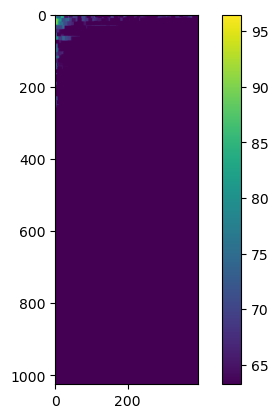

In [365]:
def custom_filter(img, func, ws, pad_value=0.0):
    # PAD
    img_big = pad_value * np.ones((img.shape[0] + 2*ws[0], img.shape[1] + 2*ws[1]))
    img_big[ws[0]:-ws[0], ws[1]:-ws[1]] = img
    out = np.zeros_like(img)
    for i in range(ws[0], img_big.shape[0]-ws[0]):
        for j in range(ws[1], img_big.shape[1]-ws[1]):
            I, J = i-ws[0], j-ws[1]
            out[I, J] = func(img_big[i-ws[0]:i+ws[0]+1, j-ws[1]:j+ws[1]+1])

    return out   

plt.imshow(custom_filter(X_db, np.min, [5, 5], pad_value=1e7))
plt.colorbar()

In [69]:
# file = Path("../instruments/YDP-GrandPiano-20160804/samples/piano057v095.wav")
# file = Path("../instruments/YDP-GrandPiano-20160804/samples/piano057v095.wav")
# file2 = Path("../instruments/YDP-GrandPiano-20160804/samples/piano048v105.wav")
# midi_num = 21
# print(librosa.midi_to_note(midi_num))

file = Path("../instruments/SalC5Light2/samples/A2v1L.wav")
# file = instrument_dir / f"A4v1L.wav"
# file = instrument_dir / f"A0v1L.wav"
y, sr = librosa.load(file)
# y2, sr = librosa.load(file2)
# y = (y[:3*sr+1]+y2[:3*sr+1])
ipd.Audio(y, rate=sr)

/var/folders/xq/1wqb95ln7554qvg6qty9v2fh0000gp/T/ipykernel_17974/819948551.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spec_db = librosa.amplitude_to_db(spec)


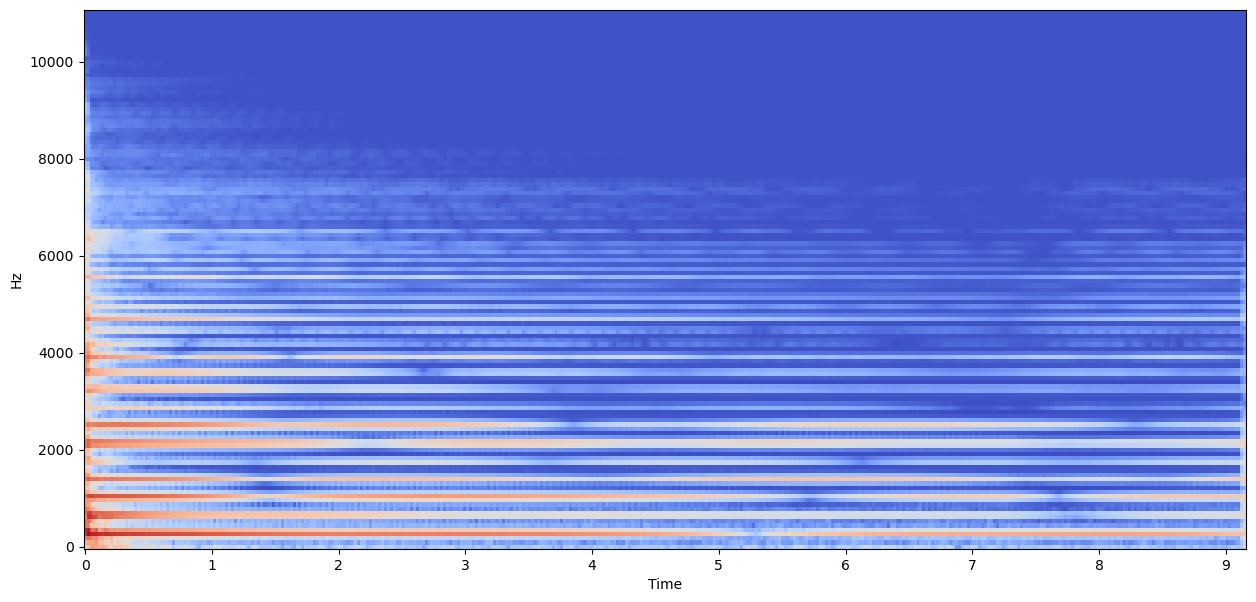

In [70]:
fig, ax = plt.subplots(1, 1, figsize=[15, 7])
spec = librosa.stft(y)
spec_db = librosa.amplitude_to_db(spec)
mel_spec = librosa.feature.melspectrogram(S=spec_db)
# mel_spec = librosa.amplitude_to_db(mel_spec)
librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis="hz")

/var/folders/xq/1wqb95ln7554qvg6qty9v2fh0000gp/T/ipykernel_17974/966925931.py:2: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(spec, )


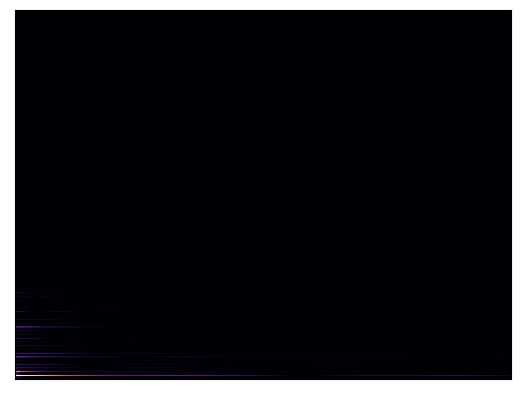

In [71]:
spec = librosa.stft(y)
librosa.display.specshow(spec, )

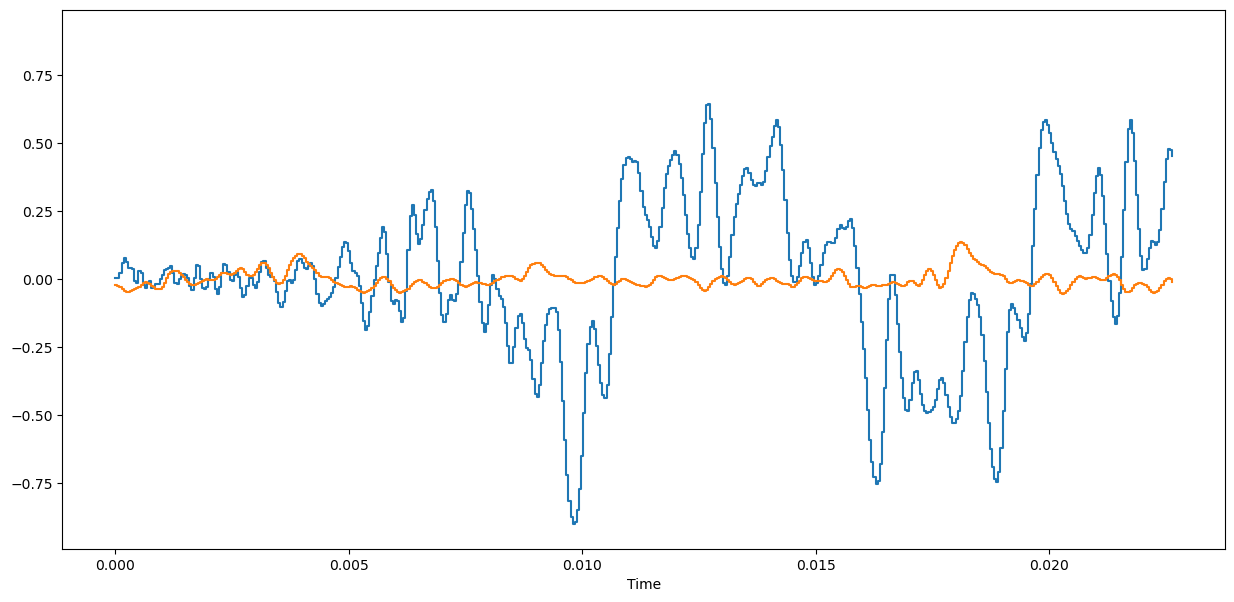

In [72]:
fig, ax = plt.subplots(1, 1, figsize=[15, 7])
spec = librosa.stft(y)
# spec.imag = 0.0
# spec_db = librosa.amplitude_to_db(spec)
# mel_spec = librosa.feature.melspectrogram(S=spec)
# mel_spec = librosa.amplitude_to_db(mel_spec)
# librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis="hz")
# wf = librosa.istft(spec)

# reverse_spec = librosa.db_to_amplitude(spec_db)
wf = librosa.istft(np.abs(spec))
I = np.s_[:500]
librosa.display.waveshow(y[I])
librosa.display.waveshow(wf[I])

In [73]:
ipd.Audio(y, rate=sr)

In [74]:
ipd.Audio(wf, rate=sr)

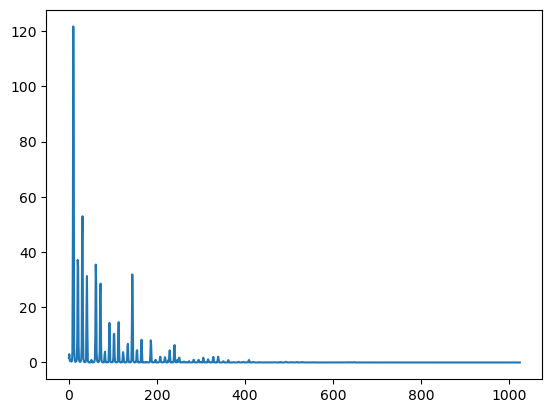

In [75]:
plt.plot(np.abs(spec[:, 20]))

In [89]:
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C1'),
                                             fmax=librosa.note_to_hz('C5'))

In [94]:
nyquist = sr/2
x = np.abs(spec[:, 20], )
this_f0 = f0[20]
min_freq = nyquist/len(x)
freqs = np.arange(len(x))*min_freq
idx_peak = librosa.util.peak_pick(
    x,
    pre_max=5,
    post_max=5,
    pre_avg=5,
    post_avg=5,
    delta=0.0,
    wait=1
)
plt.plot(freqs, x)
plt.plot(min_freq*idx_peak, x[idx_peak], 'o')
plt.plot([this_f0, this_f0], [0, 100], 'r')
plt.xlim([.0, 3.5*this_f0])


ParameterError: input array must be one-dimensional

In [209]:
def clean_spec(y, max_mult: float=30.0, ws: int = 2):
    spec = librosa.stft(y)
    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C0'),
                                             fmax=librosa.note_to_hz('C7'))
    f0 = np.nanmean(f0)
    # amps = np.zeros(max_spec.shape[1])
    out = np.zeros_like(spec)
    for i_f in range(spec.shape[1]):
        x = np.abs(spec[:, i_f], )

        # print(this_f0)
        mult_freqs = np.concatenate([np.array([0.25, 0.5]), np.arange(1.0, max_mult)])
        # print(mult_freqs)
        Is = [np.argmin(np.abs(freqs - i * f0)) for i in mult_freqs]
        
        # print(Is)
        for i in Is:
            # print("--")
            # print(i)
            # print(x[i-ws:i+ws+1])
            # print(out[i,i_f])
            out[i,i_f] = np.max(x[i-ws:i+ws+1])
    return out, spec

In [233]:
def clean_spec(y):
    spec = librosa.stft(y)
    out = np.zeros_like(spec)
    for i_f in range(spec.shape[1]):
        x = librosa.amplitude_to_db(np.abs(spec[:, i_f], ))
        idx_peak = librosa.util.peak_pick(
            x,
            pre_max=1,
            post_max=1,
            pre_avg=1,
            post_avg=1,
            delta=0.0,
            wait=1
        )
        out[idx_peak, i_f] = spec[idx_peak, i_f]
    return out, spec

In [234]:
c_spec, spec = clean_spec(y)

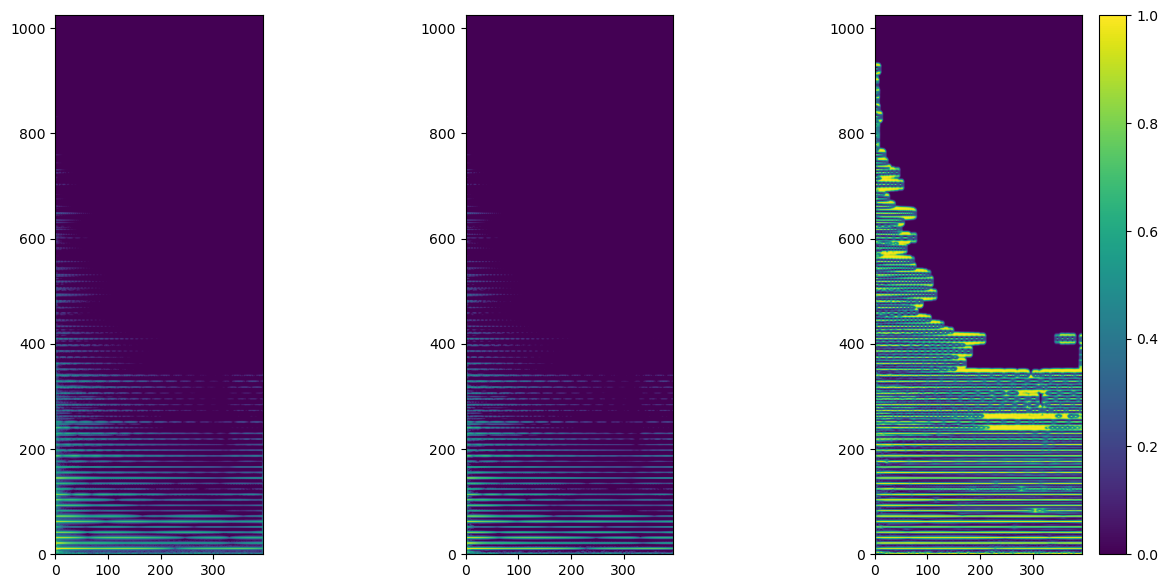

In [364]:
fig, ax = plt.subplots(1, 3, figsize=[15, 7])
from skimage import filters
# X = librosa.amplitude_to_db(np.abs(spec))[:400, :]
X = np.abs(spec)#[:400, :]
plt.sca(ax[0])
plt.imshow(librosa.amplitude_to_db(X), origin='lower')
# plt.colorbar()
X_db = librosa.amplitude_to_db(X, ref=np.min(X))
mask = X>filters.gaussian(X, sigma=[3, 0]).astype(float)
mask = filters.gaussian(mask, sigma=[1, 1])

mask2 = X_db/filters.gaussian(X_db, sigma=[2, 0]).astype(float)
mask2 = filters.gaussian(mask2, sigma=[1, 1])

mask = mask2

tol = 1.0/(2**16)
m, M = np.percentile(mask, [10, 90])
m = custom_filter(mask, np.min, [3, 3], pad_value=1e10)
M = custom_filter(mask, np.max, [3, 3], pad_value=0.0)
m = filters.gaussian(m, 1)
M = filters.gaussian(M, 1)
mask = (mask - m) / (tol + M - m)
# print(m.shape, mask.shape, mask[0].shape)
# for i in range(mask.shape[0]):
#     mask[i] = (mask[i] - m[i]) / (tol + M[i] - m[i])

mask = np.clip(mask, 0, 1)

plt.sca(ax[1])
plt.imshow(librosa.amplitude_to_db(X*mask), origin='lower')

plt.sca(ax[2])
plt.imshow(mask, origin='lower')
plt.colorbar()

# plt.colorbar()
# plt.sca(ax[1])
# plt.imshow(rest.denoise_tv_chambolle(X_db), origin='lower')

In [343]:
ipd.Audio

1.52587890625e-05

In [339]:
# plt.imshow(M - m)
# np.min((tol + M - m))
# tol = 1e-4

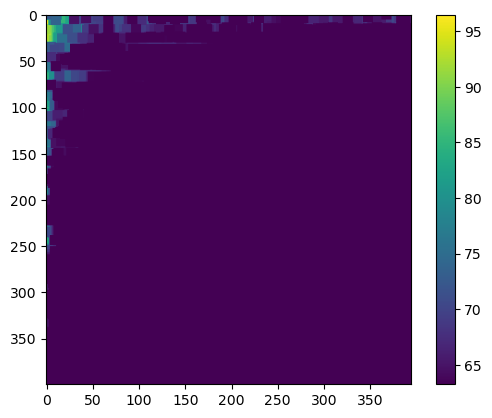

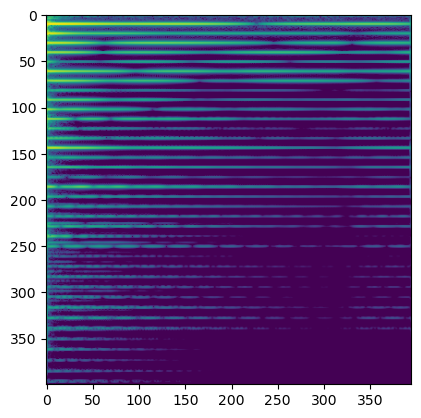

In [315]:
from skimage import restoration as rest
plt.imshow(rest.denoise_tv_chambolle(X_db))

/var/folders/xq/1wqb95ln7554qvg6qty9v2fh0000gp/T/ipykernel_17974/1322422818.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(c_spec), cmap='seismic')
/var/folders/xq/1wqb95ln7554qvg6qty9v2fh0000gp/T/ipykernel_17974/1322422818.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  t = librosa.display.specshow(librosa.amplitude_to_db(spec), cmap='seismic', y_axis='linear')


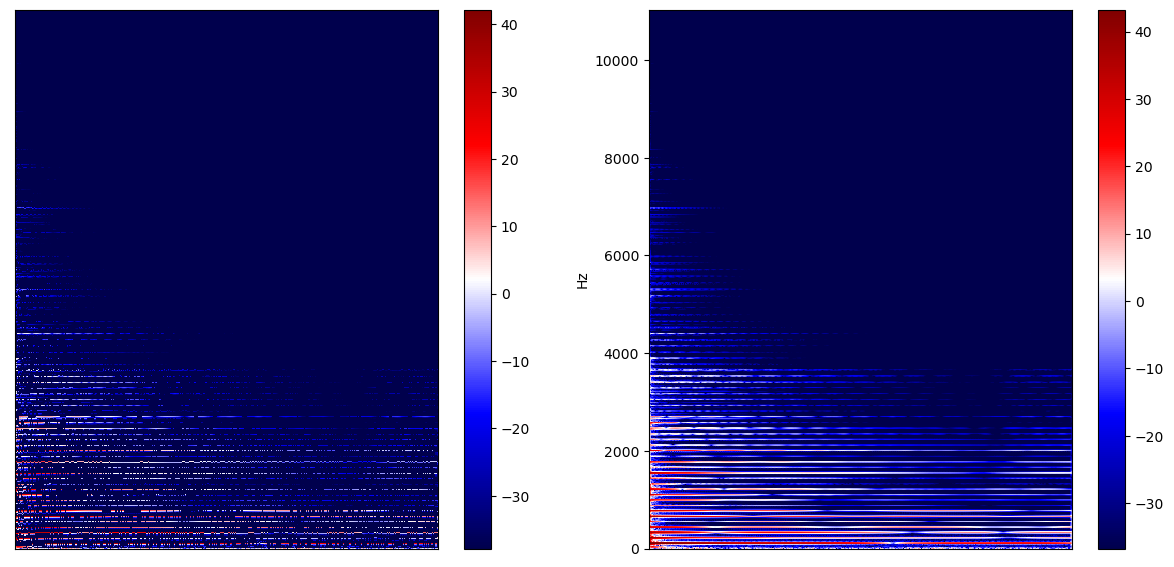

In [297]:
fig, ax = plt.subplots(1, 2, figsize=[15, 7])
plt.sca(ax[0])
librosa.display.specshow(librosa.amplitude_to_db(c_spec), cmap='seismic')
plt.colorbar()
plt.sca(ax[1])
t = librosa.display.specshow(librosa.amplitude_to_db(spec), cmap='seismic', y_axis='linear')
plt.colorbar()

In [237]:
ipd.Audio(librosa.istft(spec), rate=sr)

In [238]:
ipd.Audio(librosa.istft(c_spec), rate=sr)

In [412]:
out = spec.copy()
# out[::2] = 0.0
ipd.Audio(librosa.istft(out), rate=sr)

/var/folders/xq/1wqb95ln7554qvg6qty9v2fh0000gp/T/ipykernel_17974/1688053890.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  plt.imshow(librosa.amplitude_to_db(out)[:400])


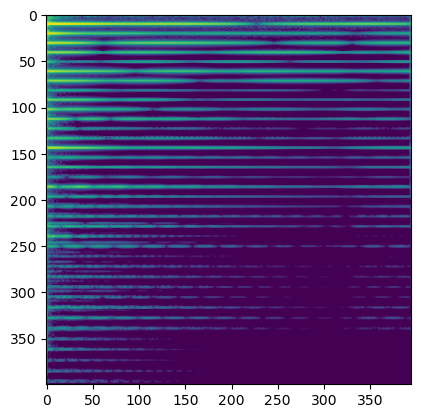

In [413]:
plt.imshow(librosa.amplitude_to_db(out)[:400])